# Invertible Neural Networks

- Forward model is well defined, but inverse problem is ill defined:   



 
<img src="car.png" alt="My Diagram" width="500px"/>



## Look at the distribution of 4-wheels vehicles in the population

<img src="4_wheels_veicles_distribution.png" alt="My Diagram" width="500px"/>


## The pdf conditioned on the observation is 


<img src="pdf_4_wheels.png" alt="My Diagram" width="500px"/>


# The problem of the robotic arm
(Ardizzone et Al.)


A robotic arm, made of
- 4 free segments and 3 joints
- bounded to the wall
- free on the other side

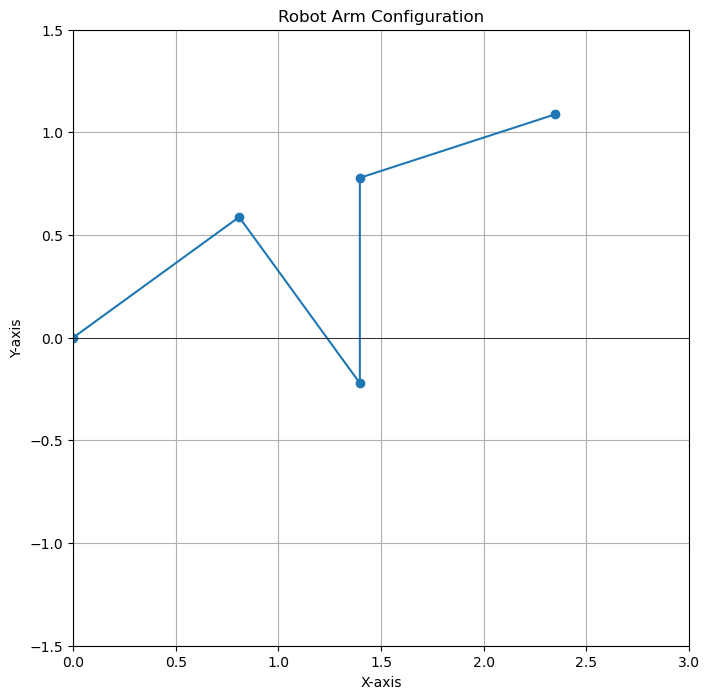

In [12]:
import numpy as np


angle_joint_wall= 0.2*np.pi
angle_joint1= -0.3*np.pi
angle_joint2= 0.5*np.pi
angle_joint3= 0.1*np.pi

point1= np.array([0.0, 0.0])
point2= np.array([np.cos(angle_joint_wall), np.sin(angle_joint_wall)])
point3= point2 + np.array([np.cos(angle_joint1), np.sin(angle_joint1)])
point4= point3 + np.array([np.cos(angle_joint2), np.sin(angle_joint2)])
point5= point4 + np.array([np.cos(angle_joint3), np.sin(angle_joint3)])


points= np.array([point1, point2, point3, point4, point5])

#plot the points with segments connecting them
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.plot(points[:, 0], points[:, 1], marker='o')
plt.xlim(0, 3)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.grid()
plt.title("Robot Arm Configuration")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Now set a uniform prior for each angle, to be in the range $[-\pi/2 + \pi/2]$

In [13]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt

@njit(parallel=True)
def compute_arms(angles):
    n = angles.shape[0]
    pts = np.zeros((n, 5, 2), dtype=np.float64)
    for i in prange(n):
        # base
        pts[i, 0, 0] = 0.0
        pts[i, 0, 1] = 0.0
        # first segment
        x1 = np.cos(angles[i, 0])
        y1 = np.sin(angles[i, 0])
        pts[i, 1, 0] = x1
        pts[i, 1, 1] = y1
        # second segment
        x2 = x1 + np.cos(angles[i, 1])
        y2 = y1 + np.sin(angles[i, 1])
        pts[i, 2, 0] = x2
        pts[i, 2, 1] = y2
        # third segment
        x3 = x2 + np.cos(angles[i, 2])
        y3 = y2 + np.sin(angles[i, 2])
        pts[i, 3, 0] = x3
        pts[i, 3, 1] = y3

        # fourth segment
        x4 = x3 + np.cos(angles[i, 3])
        y4 = y3 + np.sin(angles[i, 3])
        pts[i, 4, 0] = x4
        pts[i, 4, 1] = y4
        
    return pts

# --------------------------------------------------
# Usage
np.random.seed(42)
num_arms = 10000000
angles = np.zeros((num_arms, 4))
angles[:, 0] = np.random.normal(0, 0.25, size=num_arms)
angles[:, 1] = np.random.normal(0, 0.5, size=num_arms)
angles[:, 2] = np.random.normal(0, 0.5, size=num_arms)
angles[:, 3] = np.random.normal(0, 0.5, size=num_arms)


# First call will compile; subsequent calls are very fast
points = compute_arms(angles)
print(points.shape)  # Should be (10000, 4, 2)

(10000000, 5, 2)


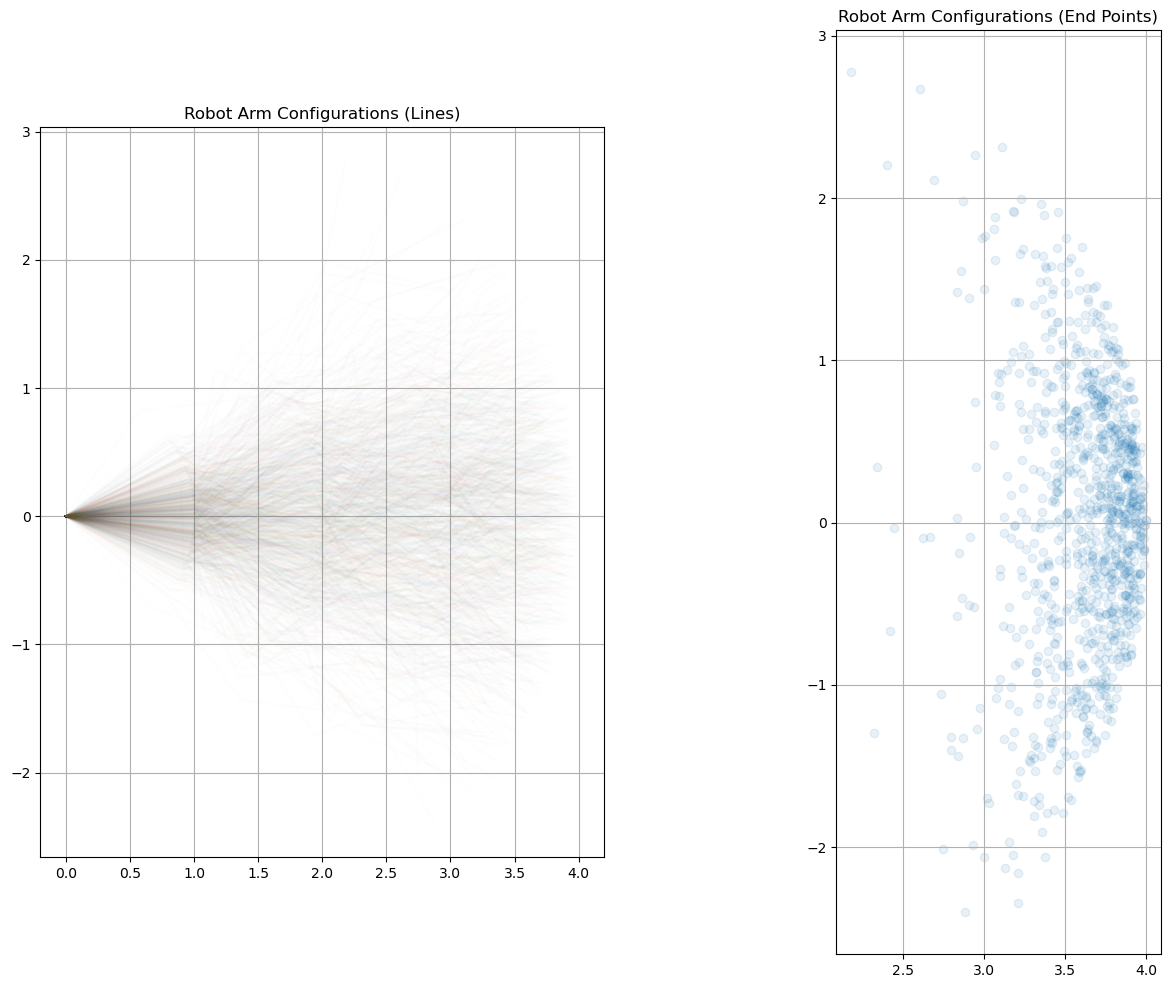

In [14]:

n_shown= 1000

# Plot as before
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
ax1.set_title("Robot Arm Configurations (Lines)")
for pts in points[:n_shown]:
    ax1.plot(pts[:,0], pts[:,1], alpha=0.01)
ax1.set_aspect('equal')
ax1.grid()

ax2.set_title("Robot Arm Configurations (End Points)")
ax2.scatter(points[:n_shown,4,0], points[:n_shown,4,1], alpha=0.1)
ax2.set_aspect('equal')
ax2.grid()

plt.show()


# Lets say I observe the endpoint of the arm in a particular position, what can I say about the joint angles?

An Approximate bayesian approach

(10000000, 5, 2)
(10000000, 2)
(10000000,)


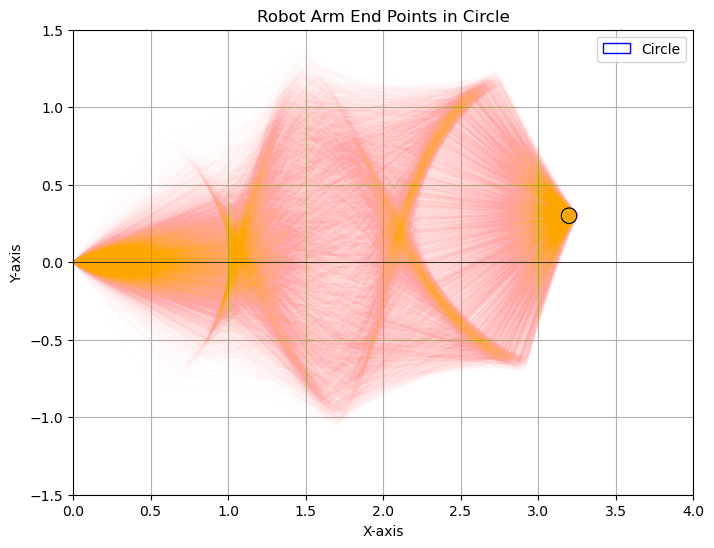

In [12]:
print(points.shape)

#select a circular area
circle_center= np.array([3.2, 0.3])
circle_r= 0.05

endpoints= points[:, 4, :]
print(endpoints.shape)  # Should be (10000, 2)
mask_in_circle = np.linalg.norm(endpoints - circle_center, axis=1) < circle_r
print(mask_in_circle.shape)

points_in_circle = points[mask_in_circle]
angles_in_circle = angles[mask_in_circle, :]

# Plot the points in the circle
plt.figure(figsize=(8, 8))
plt.plot(points_in_circle[:, :, 0].T, points_in_circle[:, :, 1].T, alpha=0.002, color='orange')
plt.gca().add_patch(plt.Circle(circle_center, circle_r, color='blue', fill=False, label='Circle'))
plt.xlim(0, 4)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.grid()
plt.title("Robot Arm End Points in Circle")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

# and get the distribution of angles  $\theta_1$, $\theta_2$, $\theta_3$

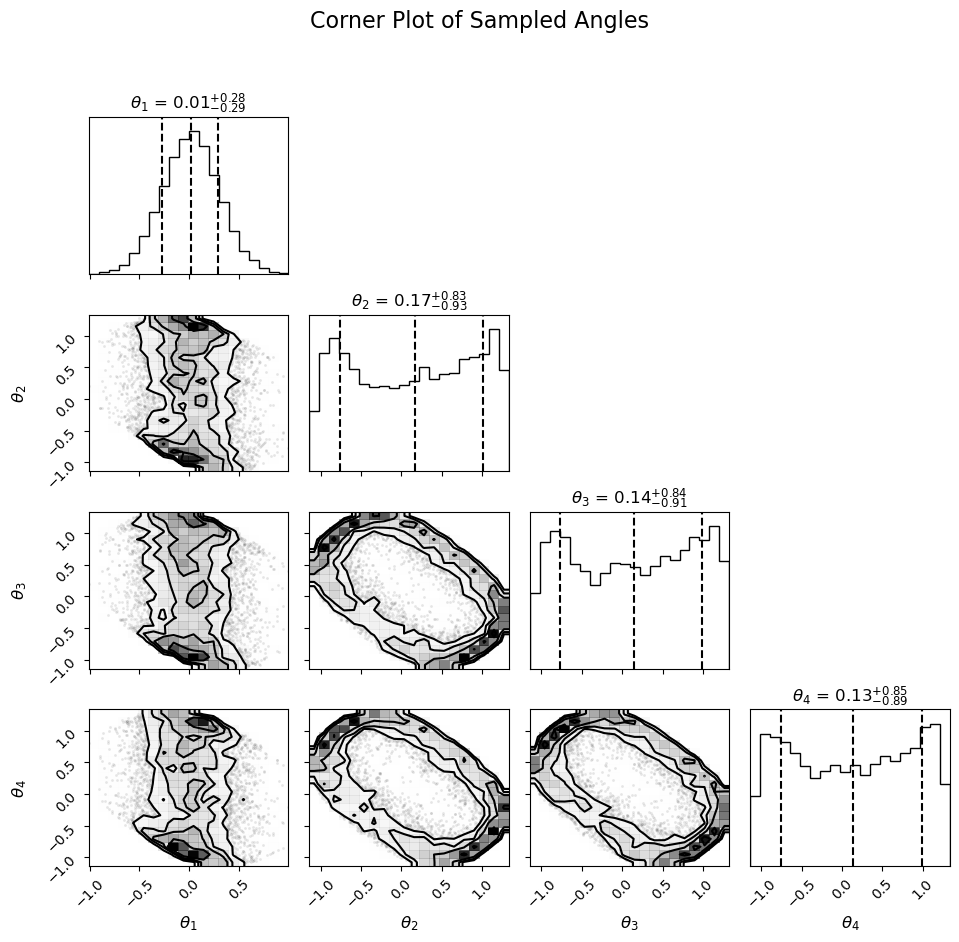

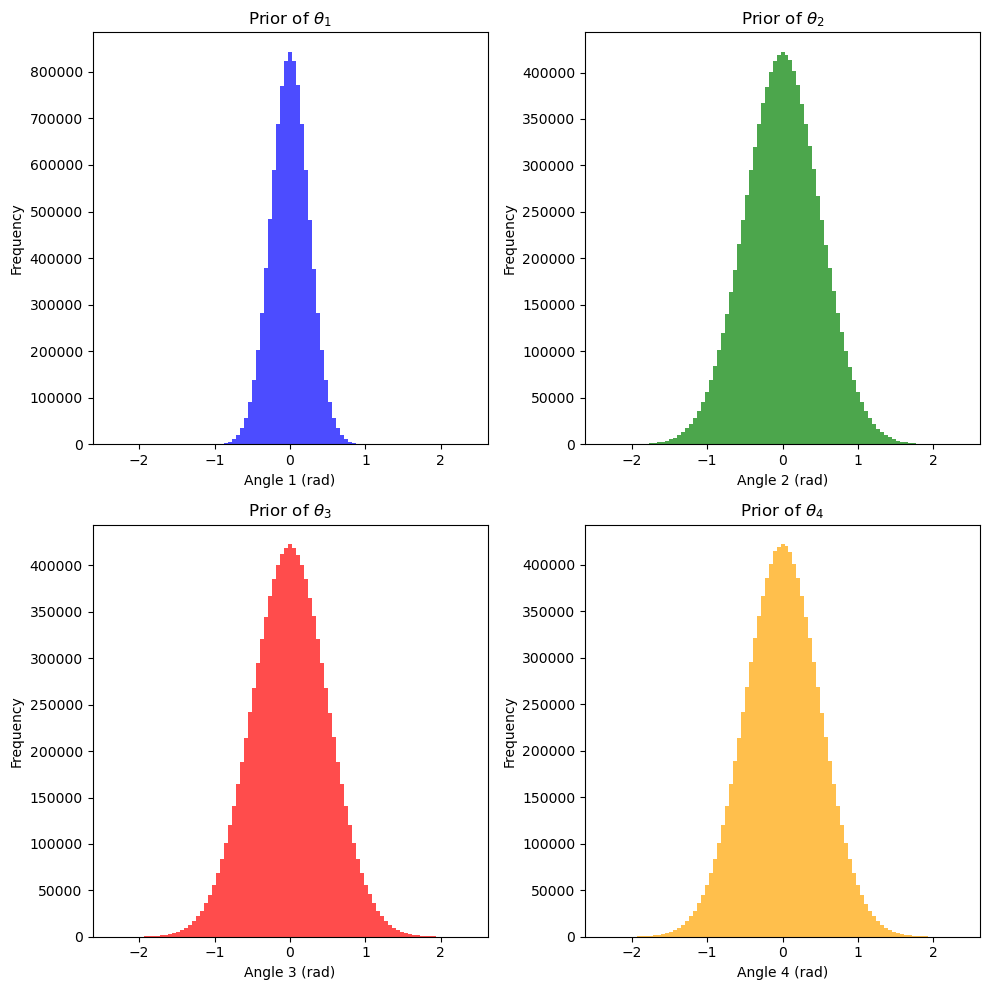

In [21]:
import corner

labels = [r"$\theta_1$", r"$\theta_2$", r"$\theta_3$", r"$\theta_4$"]

# make the corner plot
fig = corner.corner(
    angles_in_circle,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".2f",
    label_kwargs={"fontsize": 12},
    title_kwargs={"fontsize": 12}
)

# add a super‐title and tighten layout
fig.suptitle("Corner Plot of Sampled Angles", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


plt.figure(figsize=(10, 10))

# Subplot for theta_1
plt.subplot(2, 2, 1)
plt.hist(angles[:, 0], bins=np.linspace(-np.pi/1.2, np.pi/1.2, 100), color='blue', alpha=0.7)
plt.title(r"Prior of $\theta_1$")
plt.xlabel("Angle 1 (rad)")
plt.ylabel("Frequency")
plt.xlim(-np.pi/1.2, np.pi/1.2)

# Subplot for theta_2
plt.subplot(2, 2, 2)
plt.hist(angles[:, 1], bins=np.linspace(-np.pi/1.2, np.pi/1.2, 100), color='green', alpha=0.7)
plt.title(r"Prior of $\theta_2$")
plt.xlabel("Angle 2 (rad)")
plt.ylabel("Frequency")
plt.xlim(-np.pi/1.2, np.pi/1.2)

# Subplot for theta_3
plt.subplot(2, 2, 3)
plt.hist(angles[:, 2], bins=np.linspace(-np.pi/1.2, np.pi/1.2, 100), color='red', alpha=0.7)
plt.title(r"Prior of $\theta_3$")
plt.xlabel("Angle 3 (rad)")
plt.ylabel("Frequency")
plt.xlim(-np.pi/1.2, np.pi/1.2)

# Subplot for theta_4
plt.subplot(2, 2, 4)
plt.hist(angles[:, 3], bins=np.linspace(-np.pi/1.2, np.pi/1.2, 100), color='orange', alpha=0.7)
plt.title(r"Prior of $\theta_4$")
plt.xlabel("Angle 4 (rad)")
plt.ylabel("Frequency")
plt.xlim(-np.pi/1.2, np.pi/1.2)

plt.tight_layout()
plt.show()

# Clarify the ABC formalism in this case

# The classical approach: MCMC sampling

In [37]:
import numpy as np
import emcee

# -- your existing models/prior --
def analitical_model(theta1, theta2, theta3, theta4):
    """Analytical model of the robot arm."""
    x1 = np.cos(theta1)
    y1 = np.sin(theta1)
    x2 = x1 + np.cos(theta2)
    y2 = y1 + np.sin(theta2)
    x3 = x2 + np.cos(theta3)
    y3 = y2 + np.sin(theta3)
    x4 = x3 + np.cos(theta4)
    y4 = y3 + np.sin(theta4)

    return np.array([x4, y4])

def prior(theta1, theta2, theta3, theta4):
    """Prior density of the angles (independent Gaussians)."""
    p1 = np.exp(-0.5 * (theta1**2 / 0.25**2)) / (0.25 * np.sqrt(2 * np.pi))
    p2 = np.exp(-0.5 * (theta2**2 / 0.5**2))  / (0.5  * np.sqrt(2 * np.pi))
    p3 = np.exp(-0.5 * (theta3**2 / 0.5**2))  / (0.5  * np.sqrt(2 * np.pi))
    p4 = np.exp(-0.5 * (theta4**2 / 0.5**2))  / (0.5  * np.sqrt(2 * np.pi))

    return p1 * p2 * p3 * p4  

# -- log‐probability functions --
def log_prior(theta):
    θ1, θ2, θ3, θ4 = theta
    p = prior(θ1, θ2, θ3, θ4)
    return np.log(p) if p > 0 else -np.inf

def log_likelihood(theta, data, sigma=0.01):
    model = analitical_model(*theta)
    resid = data - model
    return -0.5 * np.sum((resid / sigma)**2) \
           - len(data) * np.log(sigma * np.sqrt(2 * np.pi))

def log_posterior(theta, data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data)

# -- setup emcee sampler --
data = np.array([3.2, 0.3])
ndim = 4
nwalkers = 100

# initialize walkers in a small Gaussian ball around zero
p0 = np.random.normal(loc=0.0, scale=[0.5,0.5,0.5, 0.5], size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data,))

# 1) burn‐in
print("Running burn‐in...")
p0, _, _ = sampler.run_mcmc(p0, 20000, progress=True)
sampler.reset()

# 2) production run
print("Running production...")
sampler.run_mcmc(p0, 30000, progress=True)

# sampler.chain has shape (nwalkers, nsteps, ndim)
samples = sampler.get_chain(flat=True)  # shape = (nwalkers*nsteps, ndim)
print(f"Shape of flattened chain: {samples.shape}")

# Optionally inspect means & standard deviations:
mean_est = np.mean(samples, axis=0)
std_est  = np.std(samples, axis=0)
print("Posterior means:", mean_est)
print("Posterior stds: ", std_est)



Running burn‐in...


100%|██████████| 20000/20000 [00:46<00:00, 433.94it/s]


Running production...


100%|██████████| 30000/30000 [01:10<00:00, 424.68it/s]


Shape of flattened chain: (3000000, 4)
Posterior means: [0.03659034 0.06419254 0.10874647 0.16375742]
Posterior stds:  [0.30215023 0.77218781 0.70748672 0.69901101]


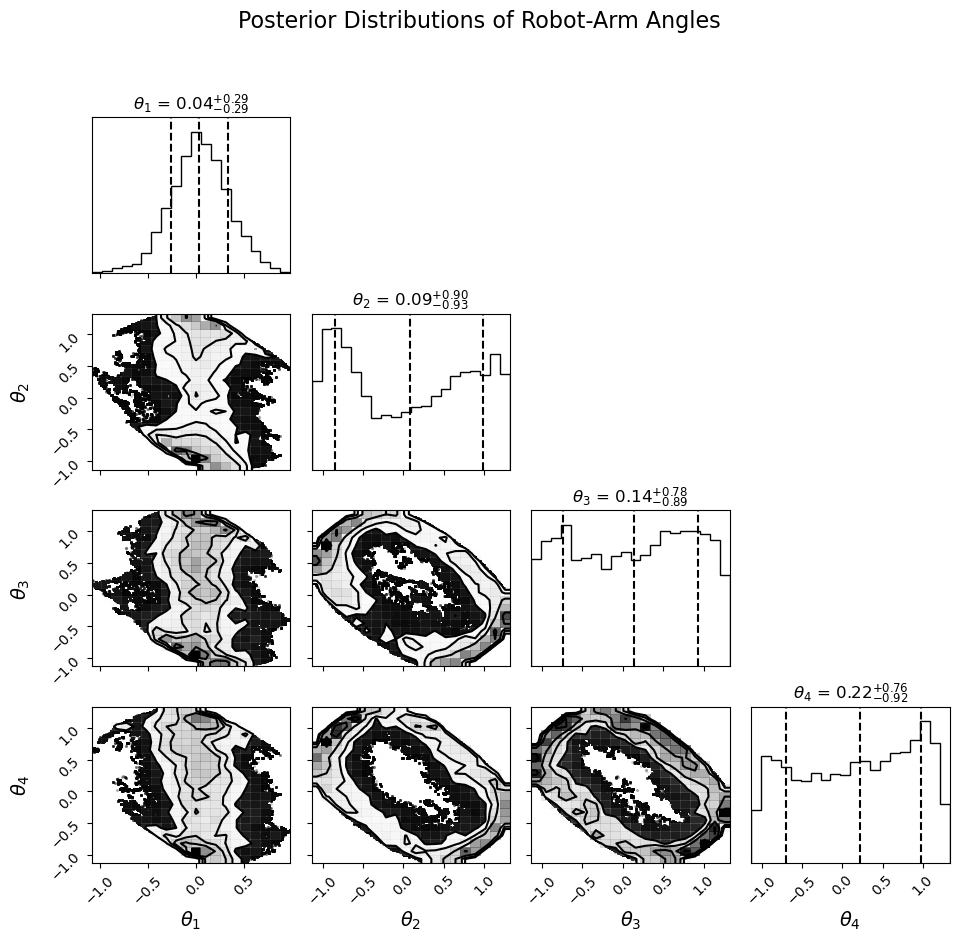

In [38]:
import corner
import matplotlib.pyplot as plt

# assume `samples` is your flattened MCMC chain of shape (n_draws, 3)
# and you ran the sampler as in the previous example.

# Optional: give each dimension a name
labels = [r"$\theta_1$", r"$\theta_2$", r"$\theta_3$", r"$\theta_4$"]

# Make the corner plot
fig = corner.corner(
    samples,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    truths=None  # or e.g. [θ1_true, θ2_true, θ3_true] if you know them
)

# Add a super‐title and tighten layout
fig.suptitle("Posterior Distributions of Robot‐Arm Angles", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


# What is an Invertible Neural Network?

In this case, the forward model maps three parameters into two:
$$
    (\theta_1, \theta_2, \theta_3)\rightarrow (x_3, y_3)
$$

If we learn with a neural network the forward, we will not learn a bijective mapping:
- We cannot have a bijection between $\mathbb{R}^3$ to $\mathbb{R}^2$

- If there was a way to have some kind of bijection, we could reverse it to get the inverse mapping

<img src="Inn_scheme.png" alt="My Diagram" width="1000px"/> 

credits https://hci.iwr.uni-heidelberg.de/vislearn/inverse-problems-invertible-neural-networks/#inverse-problems

# We need a neural architecture that is reversible, and cheaply

As we will see, we also would like it to have easly computable jacobian


The input of the reversible block is a vector $\boldsymbol{u}$: We split it in two halfes $\boldsymbol{u}_1$ and $\boldsymbol{u}_2$.

These are transformed by the reversible block into $\boldsymbol{v}_1$ and $\boldsymbol{v}_2$ according to the following transformations:


$$
    \boldsymbol{v}_1=\boldsymbol{u}_1 \odot \exp(s_2(\boldsymbol{u}_2))+t_2(\boldsymbol{u}_2)
$$
$$
    \boldsymbol{v}_2=\boldsymbol{u}_2 \odot \exp(s_1(\boldsymbol{v}_1))+t_1(\boldsymbol{v}_1)
$$

which are trivially invertible:

$$
    \boldsymbol{u}_2=(\boldsymbol{v}_2-t_1(\boldsymbol{v}_1))\odot (-s_1(\boldsymbol{v}_1))
$$
$$
    \boldsymbol{u}_1=(\boldsymbol{v}_1-t_2(\boldsymbol{u}_2))\odot (-s_2(\boldsymbol{u}_2))
$$


### $s_i$ and $t_i$ do not needd to be invertible themselfes!

In [ ]:
import torch
import torch.nn as nn


# ——— Coupling MLP with LeakyReLU ———
class CouplingNet(nn.Module):
    def __init__(self, dim, hidden_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)


In [9]:


# ——— Invertible affine‐coupling block ———
class InvertibleBlock(nn.Module):
    def __init__(self, s_1, s_2, t_1, t_2):
        super().__init__()
        self.s_1 = s_1
        self.s_2 = s_2
        self.t_1 = t_1
        self.t_2 = t_2

    def forward(self, u):
        d = u.shape[1] // 2
        u1, u2 = u[:, :d], u[:, d:]

        # first transform u1 ← f1(u1; u2)
        s2 = self.s_2(u2)
        t2 = self.t_2(u2)
        v1 = u1 * torch.exp(s2) + t2

        # then transform u2 ← f2(u2; v1)
        s1 = self.s_1(v1)
        t1 = self.t_1(v1)
        v2 = u2 * torch.exp(s1) + t1

        return torch.cat([v1, v2], dim=1)

    def inverse(self, v):
        d = v.shape[1] // 2
        v1, v2 = v[:, :d], v[:, d:]

        # invert second coupling: u2 = (v2 − t1(v1)) * exp(−s1(v1))
        s1 = self.s_1(v1)
        t1 = self.t_1(v1)
        u2 = (v2 - t1) * torch.exp(-s1)

        # invert first coupling: u1 = (v1 − t2(u2)) * exp(−s2(u2))
        s2 = self.s_2(u2)
        t2 = self.t_2(u2)
        u1 = (v1 - t2) * torch.exp(-s2)

        return torch.cat([u1, u2], dim=1)

    def log_jacobian(self, u):
        """Returns log |det ∂f/∂u| for each sample."""
        d = u.shape[1] // 2
        u1, u2 = u[:, :d], u[:, d:]
        s2 = self.s_2(u2)
        v1 = u1 * torch.exp(s2) + self.t_2(u2)
        s1 = self.s_1(v1)
        return s2.sum(dim=1) + s1.sum(dim=1)


# ——— Random feature permutation ———
class RandomPermutation(nn.Module):
    def __init__(self, features):
        super().__init__()
        p = torch.randperm(features)
        self.register_buffer('perm', p)
        self.register_buffer('inv_perm', torch.argsort(p))

    def forward(self, x):
        return x[:, self.perm]

    def inverse(self, y):
        return y[:, self.inv_perm]


# ——— Full INN: stack of [Permutation → Coupling] blocks ———
class INN(nn.Module):
    def __init__(self, input_dim, num_blocks=6, hidden_dim=512):
        """
        input_dim: total dims (must be even)
        num_blocks: how many coupling+permute layers
        hidden_dim: hidden units in each CouplingNet
        """
        super().__init__()
        assert input_dim % 2 == 0, "input_dim must be even"
        d2 = input_dim // 2

        layers = []
        for _ in range(num_blocks):
            # random shuffle
            layers.append(RandomPermutation(input_dim))
            # 4 coupling nets
            s1 = CouplingNet(d2, hidden_dim)
            s2 = CouplingNet(d2, hidden_dim)
            t1 = CouplingNet(d2, hidden_dim)
            t2 = CouplingNet(d2, hidden_dim)
            layers.append(InvertibleBlock(s_1=s1, s_2=s2, t_1=t1, t_2=t2))

        self.flow = nn.ModuleList(layers)

    def forward(self, x):
        """
        Returns
        -------
        z : transformed output
        log_jac : tensor of shape (batch,) giving log |det ∂z/∂x|
        """
        log_jac = x.new_zeros(x.shape[0])
        z = x
        for layer in self.flow:
            if isinstance(layer, InvertibleBlock):
                log_jac = log_jac + layer.log_jacobian(z)
            z = layer(z)
        return z, log_jac

    def inverse(self, z):
        """Invert the flow: z → x."""
        x = z
        for layer in reversed(self.flow):
            x = layer.inverse(x)
        return x




In [10]:
# instantiate a 12-dimensional INN with 8 coupling blocks:
model = INN(input_dim=4, num_blocks=8, hidden_dim=10)

# forward pass
x = torch.randn(32, 4)
print(f"Shape of input x: {x.shape}")  
z, log_j = model(x)

# invert
x_recon = model.inverse(z)
print(f"Shape of reconstructed x: {x_recon.shape}")
assert torch.allclose(x, x_recon, atol=1e-6)


Shape of input x: torch.Size([32, 4])
Shape of reconstructed x: torch.Size([32, 4])


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# — your INN classes must already be defined/imported:
#   CouplingNet, InvertibleBlock, RandomPermutation, INN
#   (as per the code we built above)

# 1) prepare data
# assume X: numpy array or tensor of shape (n_samples, 4)
#        Y: numpy array or tensor of shape (n_samples, 2)


X= angles[:100000]
Y= points[:100000, 4, :]  # use the end point coordinates as target
print(f"Shape of input X: {X.shape}")  # should be (n_samples, 4)
print(f"Shape of target Y: {Y.shape}")  # should be (n_samples, 2)

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
dataset  = TensorDataset(X_tensor, Y_tensor)
loader   = DataLoader(dataset, batch_size=64, shuffle=True)

# 2) build model + optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = INN(input_dim=4, num_blocks=6, hidden_dim=128).to(device)
opt    = torch.optim.Adam(model.parameters(), lr=1e-3)

# 3) training loop
import tqdm

num_epochs = 5
for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    for x_batch, y_batch in tqdm.tqdm(loader):
        x, y = x_batch.to(device), y_batch.to(device)

        # forward through the flow
        z, log_jac = model(x)
        y_pred   = z[:, :2]
        z_latent = z[:, 2:]  # 2 latent dims

        # 3a) regression loss
        loss_mse = F.mse_loss(y_pred, y)

        # 3b) flow negative‐log‐likelihood
        #    Gaussian prior:  log p(z)= -½||z||² + const 
        #    so  -log p(z) = ½||z||²  (we drop the const)
        log_p_z   = -0.5 * (z_latent**2).sum(dim=1)
        nll       = - (log_p_z + log_jac)         # = ½||z||² - log|det|
        loss_flow = nll.mean()

        # 3c) combined
        loss = loss_mse + loss_flow

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_loss += loss.item() * x.size(0)

    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch:03d}  Loss: {epoch_loss:.4f}")

Shape of input X: (100000, 4)
Shape of target Y: (100000, 2)


  0%|          | 0/1563 [00:00<?, ?it/s]

 20%|█▉        | 310/1563 [00:27<01:52, 11.11it/s]


KeyboardInterrupt: 